In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
pd.set_option('display.max_columns', None)

import nltk
from nltk.corpus import stopwords 
stop_words = stopwords.words('spanish')
from nltk.stem import WordNetLemmatizer
import string 


import base64
import re
from collections import Counter 


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import sklearn.feature_extraction.stop_words
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import spacy
spacy.load('es_core_news_sm')
from spacy.lang.es import Spanish
parser = Spanish()


#### Limpieza primaria del dataset

In [4]:
df = pd.read_csv('geografia_empleos_MX.csv')
df.head(2)

,Unnamed: 0,Título,Descripción,Teletrabajo,Logo_empresa,Preguntas,Tipo_empleo,Experiencia,Educación,Sector,Funciones,fraudulento,FV,Ciudad,Estado,latitud,longitud
0,0,(Pasantía) Asistente de Comunicación / E-Marke...,"Nacido en 2013, # URL_1126a42ca4e3346cc3e1a08f...",0 0,1,1,Tiempo completo,Internado,Sin especificar,Internet,Márketing,0 0,Es_Real,Cancún Quintana Roo,Quintana Roo,21.161908,-86.851528
1,1,(Senior) Desarrollador Producto en la nube (m ...,Somos una empresa de Internet de rápido crecim...,0 0,1,1,Tiempo completo,Asociar,Licenciatura,Hospitalidad,Tecnologías de la información,0 0,Es_Real,Mexicali Baja California,Baja California,32.624539,-115.452262


In [5]:
del df['Unnamed: 0']
df.head(5)

,Título,Descripción,Teletrabajo,Logo_empresa,Preguntas,Tipo_empleo,Experiencia,Educación,Sector,Funciones,fraudulento,FV,Ciudad,Estado,latitud,longitud
0,(Pasantía) Asistente de Comunicación / E-Marke...,"Nacido en 2013, # URL_1126a42ca4e3346cc3e1a08f...",0 0,1,1,Tiempo completo,Internado,Sin especificar,Internet,Márketing,0 0,Es_Real,Cancún Quintana Roo,Quintana Roo,21.161908,-86.851528
1,(Senior) Desarrollador Producto en la nube (m ...,Somos una empresa de Internet de rápido crecim...,0 0,1,1,Tiempo completo,Asociar,Licenciatura,Hospitalidad,Tecnologías de la información,0 0,Es_Real,Mexicali Baja California,Baja California,32.624539,-115.452262
2,.Desarrollador de redes,Este es un trabajo para alguien que quiere for...,0 0,1,0 0,Tiempo completo,Nivel medio superior,Sin especificar,Software de ordenador,Tecnologías de la información,0 0,Es_Real,Zapopan Jalisco,Jalisco,20.671956,-103.416501
3,.Desarrollador de redes,Quiénes somos Aya Healthcare es una organizaci...,0 0,1,0 0,Tiempo completo,No aplica,Sin especificar,Tecnología de la Información y Servicios,Consultante,0 0,Es_Real,Guanajuato Guanajuato,Guanajuato,21.019014,-101.257359
4,.Net Developer - Nuevo producto al mercado,"Por segundo año consecutivo, nuestros tecnólog...",0 0,1,0 0,Tiempo completo,Asociar,Sin especificar,Tecnología de la Información y Servicios,Tecnologías de la información,0 0,Es_Real,Nezahualcóyotl Estado de México,Edomex,19.399493,-98.989664


In [6]:
df.isnull().sum()

Título          0
Descripción     0
Teletrabajo     0
Logo_empresa    0
Preguntas       0
Tipo_empleo     0
Experiencia     0
Educación       0
Sector          0
Funciones       0
fraudulento     0
FV              0
Ciudad          0
Estado          0
latitud         0
longitud        0
dtype: int64

In [7]:
df.shape

(4371, 16)

In [8]:
df1 = df.copy()

In [9]:
df1['Teletrabajo'] = df1['Teletrabajo'].replace('0 0', 0) 
df1['Preguntas'] = df1['Preguntas'].replace('0 0', 0)
df1['Logo_empresa'] = df1['Logo_empresa'].replace('0 0', 0)
df1['fraudulento'] = df1['fraudulento'].replace('0 0', 0)

df1.head(10)

,Título,Descripción,Teletrabajo,Logo_empresa,Preguntas,Tipo_empleo,Experiencia,Educación,Sector,Funciones,fraudulento,FV,Ciudad,Estado,latitud,longitud
0,(Pasantía) Asistente de Comunicación / E-Marke...,"Nacido en 2013, # URL_1126a42ca4e3346cc3e1a08f...",0,1,1,Tiempo completo,Internado,Sin especificar,Internet,Márketing,0,Es_Real,Cancún Quintana Roo,Quintana Roo,21.161908,-86.851528
1,(Senior) Desarrollador Producto en la nube (m ...,Somos una empresa de Internet de rápido crecim...,0,1,1,Tiempo completo,Asociar,Licenciatura,Hospitalidad,Tecnologías de la información,0,Es_Real,Mexicali Baja California,Baja California,32.624539,-115.452262
2,.Desarrollador de redes,Este es un trabajo para alguien que quiere for...,0,1,0,Tiempo completo,Nivel medio superior,Sin especificar,Software de ordenador,Tecnologías de la información,0,Es_Real,Zapopan Jalisco,Jalisco,20.671956,-103.416501
3,.Desarrollador de redes,Quiénes somos Aya Healthcare es una organizaci...,0,1,0,Tiempo completo,No aplica,Sin especificar,Tecnología de la Información y Servicios,Consultante,0,Es_Real,Guanajuato Guanajuato,Guanajuato,21.019014,-101.257359
4,.Net Developer - Nuevo producto al mercado,"Por segundo año consecutivo, nuestros tecnólog...",0,1,0,Tiempo completo,Asociar,Sin especificar,Tecnología de la Información y Servicios,Tecnologías de la información,0,Es_Real,Nezahualcóyotl Estado de México,Edomex,19.399493,-98.989664
5,1099 Ventas médicas de contrato independiente,Ahora tenemos un producto único que cualquier ...,0,1,1,Otro,Asociar,Licenciatura,Práctica médica,Ventas,0,Es_Real,Irapuato Guanajuato,Guanajuato,20.678665,-101.354496
6,2 cuidadores de tiempo completo para una mujer...,¿Estás buscando un trabajo de cuidado que sea ...,0,1,1,Tiempo completo,Nivel Básico,Educación Secundaria o equivalente,Servicios financieros,Proveedor de atención sanitaria,0,Es_Real,Querétaro Querétaro,Queretaro,20.588793,-100.389888
7,2015 MBA Internship - Asesoría y Consultoría,El grupo de Asesoría y Consultoría de Green St...,0,1,1,Tiempo completo,Internado,Maestría,Servicios financieros,Consultante,0,Es_Real,Benito Juárez CDMX,CDMX,19.379406,-99.159145
8,2015 Pregrado- Asociado de Gestión de Cuentas,Abierto solo a los graduados de la clase de 20...,0,1,1,Tiempo completo,Nivel Básico,Licenciatura,Servicios financieros,Ventas,0,Es_Real,Ciudad Madero Tamaulipas,Tamaulipas,22.276875,-97.833105
9,3 cuidadores de tiempo completo para una mujer...,¿Estás buscando un trabajo a tiempo completo d...,0,1,1,Tiempo completo,Nivel Básico,Educación Secundaria o equivalente,Organización cívica y social,Proveedor de atención sanitaria,0,Es_Real,Corregidora Querétaro,Queretaro,20.533464,-100.446286


In [10]:
df1[['fraudulento']] = df1[['fraudulento']].astype(int)
df1[['Teletrabajo']] = df1[['Teletrabajo']].astype(int)
df1[['Logo_empresa']] = df1[['Logo_empresa']].astype(int)
df1[['Preguntas']] = df1[['Preguntas']].astype(int)

In [11]:
df1['fraudulento'].value_counts()


0    4278
1      93
Name: fraudulento, dtype: int64

In [15]:
# Utilizamos las librerías Spacy como herramienta de NLP y NLTK para la conversión de palabras a objetos 
# estadísticos para el análisis - stopwords


import spacy
from nltk.corpus import stopwords

nlp = spacy.load('es_core_news_lg')
stopw = stopwords.words('spanish')


In [16]:
punctuations = string.punctuation

In [17]:

def limpia_texto(docs, logging = False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 100 == 0 and logging:
            print('Procesados: {} de {} documentos'.format(counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable = ['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopw and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts) 

In [18]:
Falso_1 = [text for text in df1[df1['fraudulento'] == 1]['Descripción']]

In [19]:
Falso_1[10] # Obtenemos la primera muestra de la columna de 'Descripción' de la vacante

'Descripción corporativa Aker Solutions es un proveedor global de productos, sistemas y servicios para la industria del petróleo y el gas.\xa0Nuestra ingeniería, diseño y tecnología aportan descubrimientos a la producción y maximizan la recuperación de cada campo petrolero.\xa0Empleamos a aproximadamente 28,000 personas en aproximadamente 30 países.\xa0Vaya a # URL_0fa3f7c5e23a16de16a841e368006cae916884407d90b154dfef3976483a71ae # para obtener más información sobre nuestro negocio, personas y valores. Responsabilidades y tareas Responsables de las tareas de diseño generales dentro de su área Produzca conceptos, dibujos, ensamblajes y piezas mediante el sistema de hardware de SAP. input Responsable del cumplimiento de las normas de salud, medio ambiente y seguridad Cálculos de diseño (cálculos manuales o herramientas) para verificar la resistencia de los componentes y similares.\xa0Asistir a la organización del personal durante el trabajo de licitación cuando sea necesario Adherir a los

In [20]:
Falso_0 = [text for text in df1[df1['fraudulento'] == 0]['Descripción']] # Generamos la base de los negativos

In [21]:
Falso_1_limpieza = limpia_texto(Falso_1)
Falso_1_limpieza = ' '.join(Falso_1_limpieza).split()


In [22]:
len(Falso_1_limpieza) # Longitud de los elementos convertidos a  componentes estructurados de empleo falso 


30968

In [23]:
Falso_0_limpieza = limpia_texto(Falso_0)
Falso_0_limpieza = ' '.join(Falso_0_limpieza).split()

In [24]:
len(Falso_0_limpieza) # Longitud de los elementos convertidos a  componentes estructurados de empleo real 

1220518

In [26]:
# Comparación entre componentes falsos y verdaderos extraídos

Falso_1_cantidad = Counter(Falso_1_limpieza)
Falso_0_cantidad = Counter(Falso_0_limpieza)

In [27]:
Falso_1_palabras_comunes = [word[0] for word in Falso_1_cantidad.most_common(20)]
Falso_1_cantidades_comunes = [word[1] for word in Falso_1_cantidad.most_common(20)]

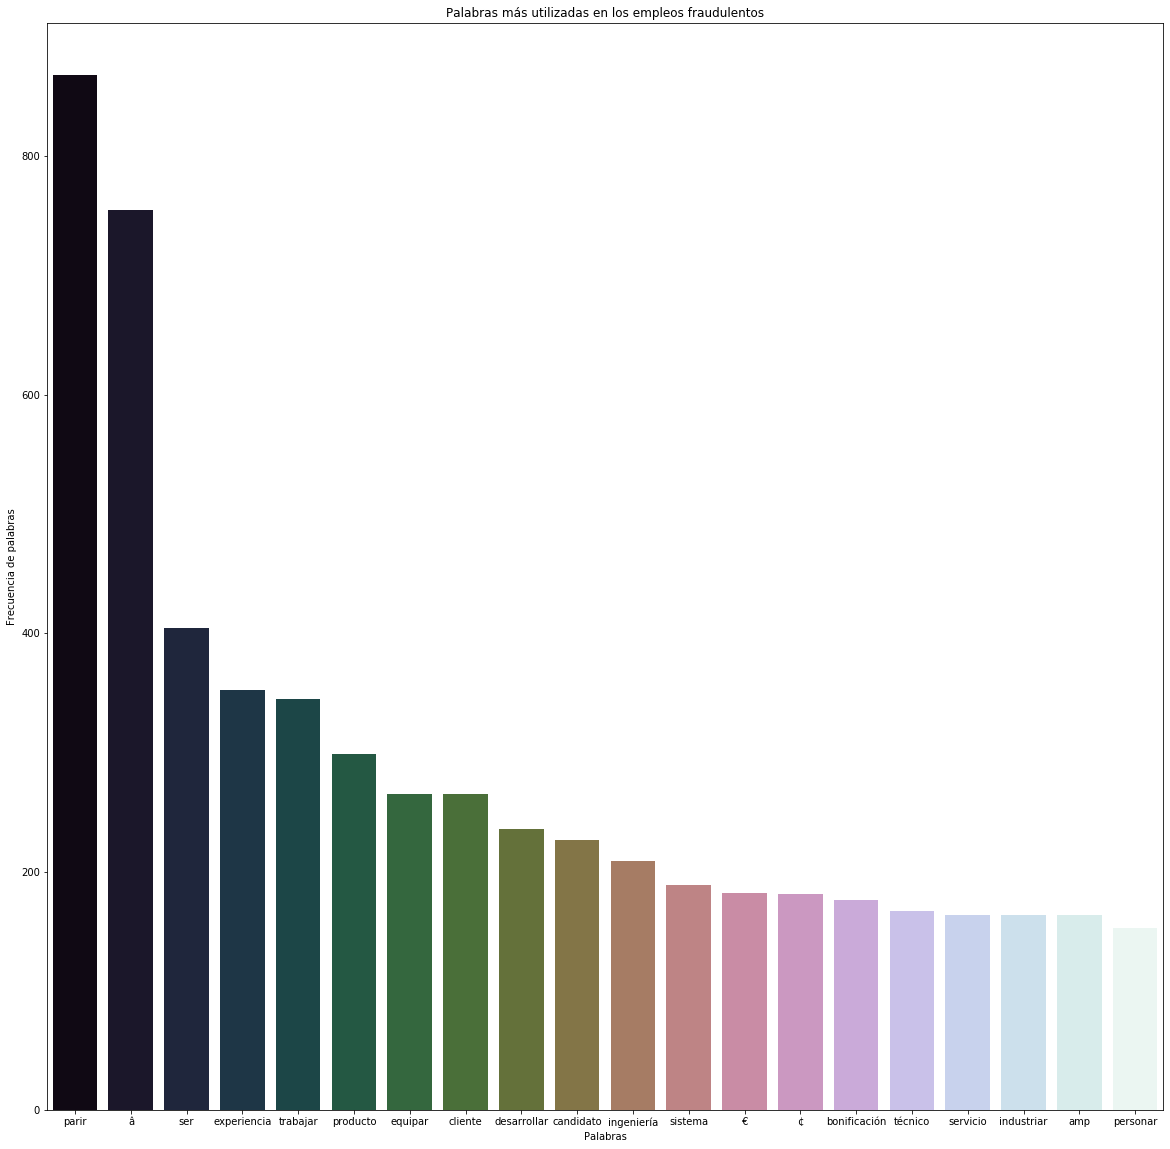

In [49]:
fig = plt.figure(figsize = (20,20))
pal = sns.color_palette('cubehelix', 20)
sns.barplot(x = Falso_1_palabras_comunes, y = Falso_1_cantidades_comunes, palette = pal)
plt.title('Palabras más utilizadas en los empleos fraudulentos')
plt.ylabel('Frecuencia de palabras')
plt.xlabel('Palabras')
plt.savefig('proyecto_bedu/Palabras_mas_utilizadas_en_falsos.png')
plt.show()


In [50]:
Falso_0_palabras_comunes = [word[0] for word in Falso_1_cantidad.most_common(20)]
Falso_0_cantidades_comunes = [word[1] for word in Falso_1_cantidad.most_common(20)]

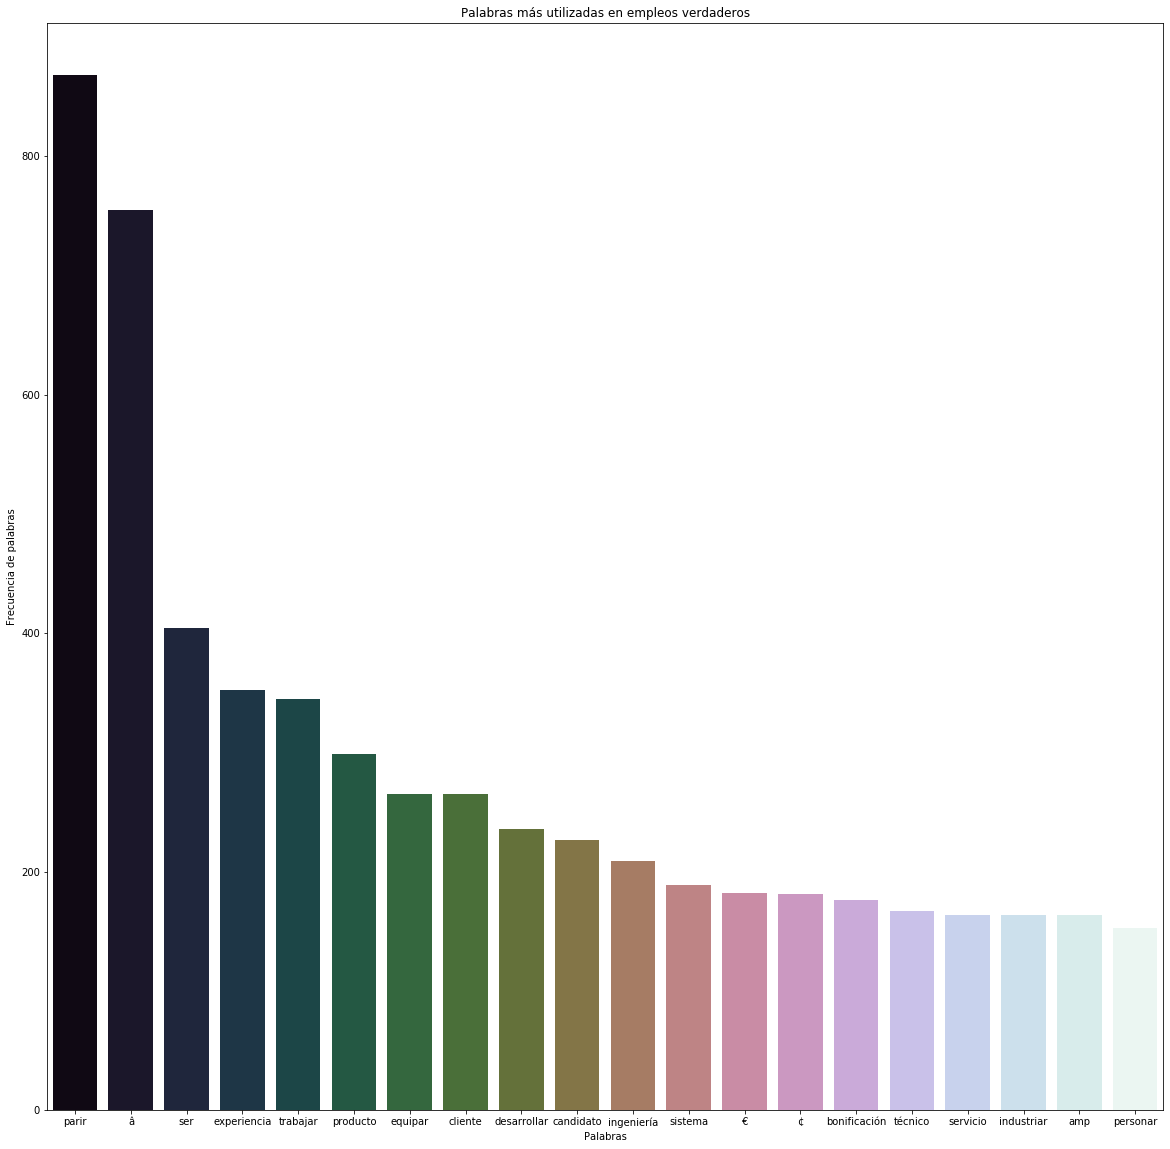

In [51]:
fig = plt.figure(figsize = (20,20))
pal = sns.color_palette('cubehelix', 20)
sns.barplot(x = Falso_0_palabras_comunes, y = Falso_0_cantidades_comunes, palette = pal)
plt.title('Palabras más utilizadas en empleos verdaderos')
plt.ylabel('Frecuencia de palabras')
plt.xlabel('Palabras')
plt.savefig('proyecto_bedu/Palabras_mas_utilizadas_en_verdaderos.png')
plt.show()

#### Limpieza adicional del dataset para ML 

In [53]:
# Descarga de Librerías para análisis NLP en español

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

import spacy
nlp = spacy.load('es_core_news_lg')
from nltk.corpus import stopwords
stopw = stopwords.words('spanish')

In [55]:
# Preparamos los módulos para el mapeo de palabras

LISTA = set(stopwords.words('spanish') + list(ENGLISH_STOP_WORDS))
SIMBOLOS = ' '.join(string.punctuation).split(' ')

In [56]:
# Definimos los tókens para el análisis de texto

def tokenizetext(sample):
    text = sample.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    tokens = parser(text)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in LISTA]
    tokens = [tok for tok in tokens if tok not in SIMBOLOS]
    return tokens

In [58]:
# Creamos los vectores correspondientes para manipular los resultados de los tókens

vectorizer = CountVectorizer(tokenizer = tokenizetext, ngram_range = (1,3), min_df= 0.6) 

In [59]:
# Definimos como objetivo de valores la columna de "Descripción"

vectorizer_features = vectorizer.fit_transform(df1['Descripción'])

In [60]:
# Comprobamos el tamaño del df

vectorizer_features.shape

(4371, 6)

In [61]:
# Recuperamos las características de los vectores almacenados 

vectorizer_features

<4371x6 sparse matrix of type '<class 'numpy.int64'>'
	with 20148 stored elements in Compressed Sparse Row format>

In [64]:
# Asignamos los atributos y valores a cada elemento de vector para Descripcion, Ciudad, FV y Estado
# con el fin de producir un punto de comparación 

df_vectorizado = pd.DataFrame(vectorizer_features.todense(), columns = vectorizer.get_feature_names())
df_vectorizado = pd.concat([df1, df_vectorizado], axis = 1)
df_vectorizado.drop('Descripción', axis = 1, inplace = True)
df_vectorizado.dropna(inplace=True)
df_vectorizado['Ciudad'] = pd.to_numeric(df['Ciudad'], errors='coerce')
df_vectorizado['FV'] = pd.to_numeric(df['FV'], errors='coerce')
df_vectorizado['Estado'] = pd.to_numeric(df['Estado'], errors='coerce')
df_vectorizado = df_vectorizado.replace(np.nan, 0, regex=True)
df_vectorizado.head(5)

,Título,Teletrabajo,Logo_empresa,Preguntas,Tipo_empleo,Experiencia,Educación,Sector,Funciones,fraudulento,FV,Ciudad,Estado,latitud,longitud,,clientes,equipo,experiencia,habilidades,trabajo
0,(Pasantía) Asistente de Comunicación / E-Marke...,0,1,1,Tiempo completo,Internado,Sin especificar,Internet,Márketing,0,0.0,0.0,0.0,21.161908,-86.851528,9,0,3,2,2,0
1,(Senior) Desarrollador Producto en la nube (m ...,0,1,1,Tiempo completo,Asociar,Licenciatura,Hospitalidad,Tecnologías de la información,0,0.0,0.0,0.0,32.624539,-115.452262,6,0,3,2,0,0
2,.Desarrollador de redes,0,1,0,Tiempo completo,Nivel medio superior,Sin especificar,Software de ordenador,Tecnologías de la información,0,0.0,0.0,0.0,20.671956,-103.416501,13,1,6,11,4,1
3,.Desarrollador de redes,0,1,0,Tiempo completo,No aplica,Sin especificar,Tecnología de la Información y Servicios,Consultante,0,0.0,0.0,0.0,21.019014,-101.257359,8,4,3,1,2,3
4,.Net Developer - Nuevo producto al mercado,0,1,0,Tiempo completo,Asociar,Sin especificar,Tecnología de la Información y Servicios,Tecnologías de la información,0,0.0,0.0,0.0,19.399493,-98.989664,14,1,2,0,0,1


In [65]:
# Nos asegurmos que cada objeto-vector esté parametrizado para que funcionen las librerías de NLP 

df_vectorizado.dtypes

Título           object
Teletrabajo       int32
Logo_empresa      int32
Preguntas         int32
Tipo_empleo      object
Experiencia      object
Educación        object
Sector           object
Funciones        object
fraudulento       int32
FV              float64
Ciudad          float64
Estado          float64
latitud         float64
longitud        float64
                  int64
clientes          int64
equipo            int64
experiencia       int64
habilidades       int64
trabajo           int64
dtype: object

In [66]:
columnas = ['Tipo_empleo', 'Experiencia', 'Educación', 'Sector', 'Funciones']
for columna in columnas: 
    encoded = pd.get_dummies(df_vectorizado[columna])
    df_vectorizado = pd.concat([df_vectorizado, encoded], axis = 1)
    

In [67]:
columnas += ['Título', 'Ciudad']
df_vectorizado.drop(columnas, axis = 1, inplace = True)

In [79]:
# Proponemos una columna con valores que funcionarán como base para la comparación vectorial 

objetivo = df_vectorizado['fraudulento']
caracteristicas = df_vectorizado.drop('fraudulento', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(caracteristicas, objetivo, test_size = 0.1, 
                                                    stratify = objetivo, random_state=42)


In [80]:
# Crearemos un par de listas vacías para ir agregando los resultados de cada análisis ML para 
# la gráfica donde expondremos los resultados de cada modelo ML implementado 

Model_Score = []
Model_Name = []

In [81]:
# Agregamos las librerías adicionales 

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

## K-Vecinos más cercanos (KNN)--------------------------------------------

In [82]:
knn = KNeighborsClassifier()
k_range = list(np.arange(2, 23, 2))
param_grid_knn = dict(n_neighbors = k_range)
print (param_grid_knn)

{'n_neighbors': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]}


In [83]:
grid_knn = GridSearchCV(knn, param_grid_knn, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 1)

In [84]:
grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   13.4s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20,
                                         22]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [85]:
grid_knn.best_score_


0.6951779988417097

In [86]:
grid_knn.best_params_

{'n_neighbors': 18}

In [87]:
knn_pred = grid_knn.predict(X_test)

In [88]:
print (roc_auc_score(y_test, knn_pred))
print (classification_report(y_test, knn_pred))

0.5


C:\Users\OSWALDO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       429
           1       0.00      0.00      0.00         9

    accuracy                           0.98       438
   macro avg       0.49      0.50      0.49       438
weighted avg       0.96      0.98      0.97       438



In [89]:
Model_Name.append('KNN')
Model_Score.append(round(roc_auc_score(y_test, knn_pred), 4))

### REGRESIÓN LOGÍSTICA-----------------------------------------------------

In [90]:
log_reg = LogisticRegression()
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty_options = ['l1', 'l2']

param_grid = dict(C = c_values, penalty = penalty_options)

grid_tfidf = GridSearchCV(log_reg, param_grid = param_grid, cv = 10, 
                          scoring = 'roc_auc', n_jobs = -1, verbose=1)

grid_tfidf.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.7s finished
C:\Users\OSWALDO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [92]:
grid_tfidf.best_score_

0.8885852928782942

In [93]:
grid_tfidf.best_params_

{'C': 1000, 'penalty': 'l2'}

In [95]:
log_reg_pred = grid_tfidf.predict(X_test)

In [96]:
roc_auc_score(y_test, log_reg_pred)

0.6076146076146077

In [97]:
print (classification_report(y_test, log_reg_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       429
           1       0.40      0.22      0.29         9

    accuracy                           0.98       438
   macro avg       0.69      0.61      0.64       438
weighted avg       0.97      0.98      0.97       438



In [98]:
Model_Name.append('Logistic_Regression')
Model_Score.append(round(roc_auc_score(y_test, log_reg_pred), 4))

### CLASIFICADOR DE SOPORTE VECTORIAL (SVC) ---------------------------------

In [99]:
svc = SVC()
kernel = ['linear', 'rbf']
param_grid_knn = dict(kernel = kernel)
print (param_grid_knn)

{'kernel': ['linear', 'rbf']}


In [100]:
grid_svc = GridSearchCV(svc, param_grid_knn, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 2)

In [101]:
grid_svc.fit(X_train, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    2.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.4s finished
C:\Users\OSWALDO\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1, param_grid={'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=2)

In [102]:
grid_svc.best_score_

0.8586039626037719

In [103]:
grid_svc.best_params_

{'kernel': 'rbf'}

In [104]:
svc_pred = grid_svc.predict(X_test)

print (roc_auc_score(y_test, svc_pred))
print (classification_report(y_test, svc_pred))

0.5


C:\Users\OSWALDO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       429
           1       0.00      0.00      0.00         9

    accuracy                           0.98       438
   macro avg       0.49      0.50      0.49       438
weighted avg       0.96      0.98      0.97       438



In [105]:
Model_Name.append('SVC')
Model_Score.append(round(roc_auc_score(y_test, svc_pred), 4))

###  CLASIFICADOR RANDOM FOREST (RFC) --------------------------------

In [106]:
rf = RandomForestClassifier()
n_estimators_range = [1, 2, 4, 8, 16, 32, 64, 100, 200]
param_grid_rf = dict(n_estimators = n_estimators_range)
grid_rf = GridSearchCV(rf, param_grid_rf, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 1)

In [107]:
grid_rf.fit(X_train, y_train)
print (grid_rf.best_score_)
print (grid_rf.best_params_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.8s finished


0.9307929555259835
{'n_estimators': 200}


In [108]:
rf_pred = grid_rf.predict(X_test)
print (roc_auc_score(y_test, rf_pred))
print (classification_report(y_test, rf_pred))

0.6111111111111112
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       429
           1       1.00      0.22      0.36         9

    accuracy                           0.98       438
   macro avg       0.99      0.61      0.68       438
weighted avg       0.98      0.98      0.98       438



In [109]:
Model_Name.append('Random_Forest')
Model_Score.append(round(roc_auc_score(y_test, rf_pred), 4))

####  CLASIFICADOR PERCEPTRÓN MULTICAPA (MLP optimizador 'ibfgs' sin estimación de params)

In [110]:
mlp = MLPClassifier(solver = 'sgd', activation = 'relu', hidden_layer_sizes = (100, 50, 30), max_iter = 1000)

In [111]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 30), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [112]:
mlp_pred = mlp.predict(X_test)
print (roc_auc_score(y_test, mlp_pred))
print (classification_report(y_test, mlp_pred))

0.5


C:\Users\OSWALDO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       429
           1       0.00      0.00      0.00         9

    accuracy                           0.98       438
   macro avg       0.49      0.50      0.49       438
weighted avg       0.96      0.98      0.97       438



In [113]:
Model_Name.append('MLP-NN (sgd)')
Model_Score.append(round(roc_auc_score(y_test, mlp_pred), 4))

#### CLASIFICADOR PERCEPTRÓN MULTICAPA (MLP -> optimizador 'adam', estima los parámetros) 

In [207]:
mlp = MLPClassifier(solver = 'adam', activation = 'relu', hidden_layer_sizes = (100, 50, 30), max_iter = 1000)

In [208]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 30), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [114]:
mlp_pred = mlp.predict(X_test)
print (roc_auc_score(y_test, mlp_pred))
print (classification_report(y_test, mlp_pred))

0.5


C:\Users\OSWALDO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       429
           1       0.00      0.00      0.00         9

    accuracy                           0.98       438
   macro avg       0.49      0.50      0.49       438
weighted avg       0.96      0.98      0.97       438



In [115]:
Model_Name.append('MLP-NN (adam)')
Model_Score.append(round(roc_auc_score(y_test, mlp_pred), 4))

#  COMPARATIVA DE MODELOS ML: 

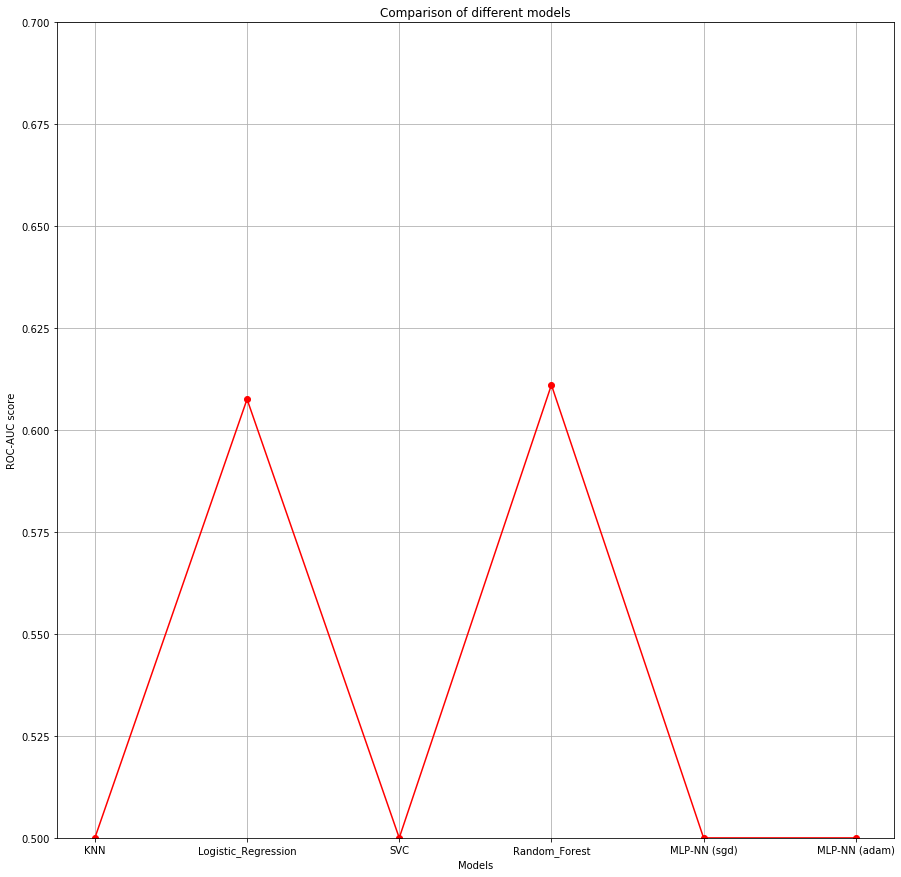

In [117]:
plt.figure(figsize = (15, 15))
plt.plot(Model_Name,Model_Score, marker = 'o', color = 'red')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('ROC-AUC score')
plt.ylim(0.5, 0.7)
plt.grid()
plt.savefig('Model_compare.jpeg')
plt.savefig('proyecto_bedu/Comparativa_modelos_ML.png')
plt.show()

### Reporte de calidad general del dataframe df1 (sin estandarización estructurada)

In [123]:
def quality_report(df1):

    """This method will do a basic data quality report for a data frame"""
        
    if (type(df1) != pd.core.frame.DataFrame):
        raise TypeError("Data must be pandas.core.frame.DataFrame")
    else: 
        columns = list(df1.columns.values)
        data_type = pd.DataFrame(df1.dtypes, columns=['Data type'])
        missing_data = pd.DataFrame(
        df1.isnull().sum(), columns=['missing values'])
        present_data = pd.DataFrame(df1.count(), columns=['present values'])
        unique_values = pd.DataFrame(columns=['unique values'])
        minimum_values = pd.DataFrame(columns=['minimum values'])
        max_values = pd.DataFrame(columns=['maximun values'])
        
        for i in columns:
            unique_values.loc[i] = [df1[i].nunique()]
            try:
                minimum_values.loc[i] = [df1[i].min()]
                max_values.loc[i] = [df1[i].max()]
            except:
                pass
        
        DQ_report = data_type.join(missing_data).join(present_data).join(
        unique_values).join(minimum_values).join(max_values)
    
    return DQ_report
quality_report(df1)

,Data type,missing values,present values,unique values,minimum values,maximun values
Título,object,0,4371,3076,(Pasantía) Asistente de Comunicación / E-Marke...,Óptico (Union Square)
Descripción,object,0,4371,3950,"""Cuidamos mucho a nuestros CarePartners para q...",â € ¢ Responda tanto las llamadas entrantes de...
Teletrabajo,int32,0,4371,2,0,1
Logo_empresa,int32,0,4371,2,0,1
Preguntas,int32,0,4371,2,0,1
Tipo_empleo,object,0,4371,5,Contrato,Tiempo completo
Experiencia,object,0,4371,7,Asociar,No aplica
Educación,object,0,4371,12,Algunos cursos de secundaria,Vocacional - Diploma HS
Sector,object,0,4371,119,Administración de educación,relaciones Gubernamentales
Funciones,object,0,4371,37,Administrativo,administración


### Reporte de calidad general del dataframe df_vectorizado (estructurado a NLP)

In [120]:
def quality_report(df_vectorizado):

    """This method will do a basic data quality report for a data frame"""
        
    if (type(df_vectorizado) != pd.core.frame.DataFrame):
        raise TypeError("Data must be pandas.core.frame.DataFrame")
    else: 
        columns = list(df_vectorizado.columns.values)
        data_type = pd.DataFrame(df_vectorizado.dtypes, columns=['Data type'])
        missing_data = pd.DataFrame(
        df_vectorizado.isnull().sum(), columns=['missing values'])
        present_data = pd.DataFrame(df_vectorizado.count(), columns=['present values'])
        unique_values = pd.DataFrame(columns=['unique values'])
        minimum_values = pd.DataFrame(columns=['minimum values'])
        max_values = pd.DataFrame(columns=['maximun values'])
        
        for i in columns:
            unique_values.loc[i] = [df_vectorizado[i].nunique()]
            try:
                minimum_values.loc[i] = [df_vectorizado[i].min()]
                max_values.loc[i] = [df_vectorizado[i].max()]
            except:
                pass
        
        DQ_report = data_type.join(missing_data).join(present_data).join(
        unique_values).join(minimum_values).join(max_values)
    
    return DQ_report
quality_report(df_vectorizado)

,Data type,missing values,present values,unique values,minimum values,maximun values
,int64,0,4371,44,0,52
Administración de educación,uint8,0,4371,2,0,1
Administración gubernamental,uint8,0,4371,2,0,1
Administrativo,uint8,0,4371,2,0,1
Adquisitivo,uint8,0,4371,2,0,1
...,...,...,...,...,...,...
habilidades,int64,0,4371,11,0,10
latitud,float64,0,4371,69,18.6783,32.6245
longitud,float64,0,4371,69,-117.038,-86.7341
relaciones Gubernamentales,uint8,0,4371,2,0,1


<div class="alert alert-block alert-info">
<b>Comentarios finales:</b> En este notebook se utilizó un dataset previamente manejado con técnicas de ETL para modelarlo y explorar el conjunto de datos colectados en un dataset de empleos en México. Posteriormente, se implementaron métodos de filtrado y enriquecimiento agregando valores como longitud y latitud con el uso de Google Maps API con el fin de arrojar el reporte de visual de la exploración y análisis de datos.
    En un segundo dataset se implementó una técnica de conversión de datos para estandarizar los valores a estructurados para las librerías de Procesamiento de Lenguaje Natural (NLP). 
    Se prosiguió con la comparación de los resultados de cada modelo implementado. 
</div>